**Importing Section**

In [ ]:
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Initializing The Path Folders of train, test, validation directories.**


In [ ]:
train_directory = "/content/drive/MyDrive/Thesis Dataset/train"
test_directory = "/content/drive/MyDrive/Thesis Dataset/test"
validation_directory = "/content/drive/MyDrive/Thesis Dataset/validation"

**Creating a inceptionV3 Model**

In [ ]:
image_size = [100, 100]
batch_size = 60
model1 = ResNet50(include_top= False, input_shape=image_size+[3], weights='imagenet')

**Generating Batches of tensor image data with real-time image augmentation**

In [ ]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

datagen_test = ImageDataGenerator(rescale = 1./255)

datagen_validation = ImageDataGenerator(rescale = 1./255)

train_generator = datagen_train.flow_from_directory(
    directory = train_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

test_generator = datagen_test.flow_from_directory(
    directory = test_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

validation_generator = datagen_validation.flow_from_directory(
    directory = validation_directory,
    target_size = image_size,
    batch_size = batch_size,
    shuffle = True
    )

Found 69085 images belonging to 9 classes.
Found 10392 images belonging to 9 classes.
Found 20529 images belonging to 9 classes.


**Adding Flatten and Dense Layers**

In [ ]:
headModel = model1.output
headModel = layers.Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(9, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel)

**Adding Optimizer**

In [ ]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
#metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!curl https://raw.githubusercontent.com/dexterfichuk/GoogleDriveCheckpoint/master/google_drive_checkpoint.py -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4522  100  4522    0     0  36176      0 --:--:-- --:--:-- --:--:-- 36176


In [ ]:
pip install httplib2==0.15.0

In [ ]:
pip install google-api-python-client==1.6

**Checkpoint Saving**

In [ ]:
# checkpoint =  ModelCheckpoint(
#     "checkpoint.h5", monitor = 'val_accuracy', #val_acc
#     verbose = 1 , save_best_only = True,
#     save_weight_only = False, mode = 'auto',
#     period = 1
#     )

from google_drive_checkpoint import GoogleDriveCheckpoint

checkpoint = GoogleDriveCheckpoint('ResNet50.h5', drive, save_best_only=True, 
                                   save_weights_only=False, 
                                   monitor = 'val_accuracy', mode = 'auto',
                                   verbose=1)



**Early Stopping**

In [ ]:
earlystop = EarlyStopping(
    monitor = 'val_accuracy', min_delta = 0, #val_acc
    patience = 10, verbose = 1, mode = 'auto'
)

**Simulating Epochs**

In [ ]:
epochs = 100
steps_per_epoch = (train_generator.n / batch_size)
steps_test = test_generator.n / batch_size
steps_validation  = validation_generator.n / batch_size





history = model.fit_generator(
    generator=train_generator,
    epochs = epochs, steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = steps_test,
    callbacks = [checkpoint, earlystop]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/100
1152/1151 [==============================] - ETA: -11s - loss: 0.4989 - accuracy: 0.8475 - precision: 0.8725 - recall: 0.8301
Epoch 00001: val_accuracy improved from -inf to 0.84990, saving model to ResNet50.h5
Uploaded file ResNet50-0.8499042391777039.h5 to drive with ID 190iZG1p0kXXk9AtFIwSCGPpg8r7_8BJG
1151/1151 [==============================] - 25114s 22s/step - loss: 0.4989 - accuracy: 0.8475 - precision: 0.8725 - recall: 0.8301 - val_loss: 0.7248 - val_accuracy: 0.8499 - val_precision: 0.8645 - val_recall: 0.8361
Epoch 2/100
1152/1151 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9356 - precision: 0.9444 - recall: 0.9278
Epoch 00002: val_accuracy improved from 0.84990 to 0.96255, saving model to ResNet50.h5
Uploaded file ResNet50-0.9625478982925415.h5 to drive with ID 1dLpYhMhgnXvIO-kgruVNnJ0hAcdkVLYA
1151/1151 [==============================] - 1726s 1s/step - loss: 0.1967 - accuracy: 0.9356 - precision: 0.9444 - recall: 0.9278 - val_loss: 

**Plotting and Graph**

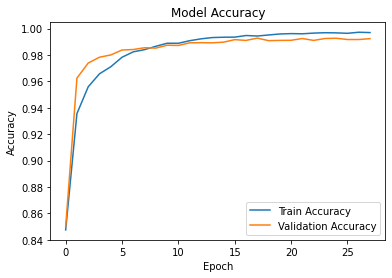

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"], loc = 'lower right')
plt.show()

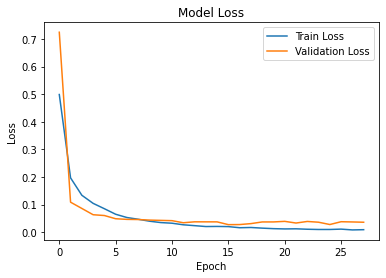

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"], loc = 'upper right')
plt.show()

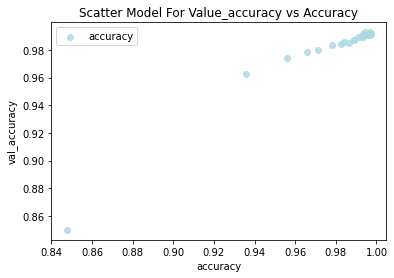

In [ ]:
plt.scatter(history.history['accuracy'],history.history['val_accuracy'], 
            label='accuracy' , color ='lightblue' ,alpha= 0.8 ,marker= 'o')
plt.ylabel('val_accuracy')
plt.xlabel('accuracy')
plt.title('Scatter Model For Value_accuracy vs Accuracy')
plt.legend(loc='upper left')

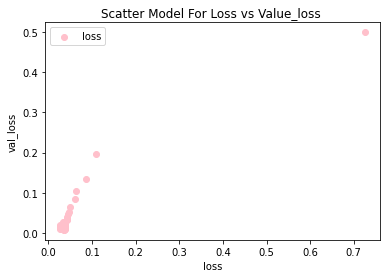

In [ ]:
plt.scatter(history.history['val_loss'],history.history['loss'],label='loss'
,color ='pink', marker= 'o')
plt.ylabel('val_loss')
plt.xlabel('loss')
plt.title('Scatter Model For Loss vs Value_loss ')
plt.legend(loc='upper left')

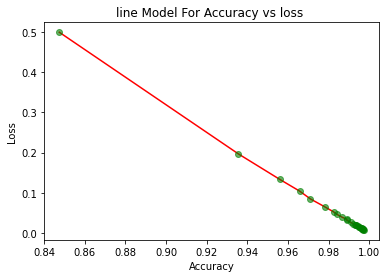

In [ ]:
plt.plot(history.history['accuracy'],history.history['loss'] ,'r-')
plt.plot(history.history['accuracy'],history.history['loss'] ,'go',alpha=0.6)
#plt.plot(history.history['val_accuracy'],history.history['val_loss'],"g-")
#plt.plot(history.history['val_accuracy'],history.history['val_loss'],"ro")
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('line Model For Accuracy vs loss ')
#plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

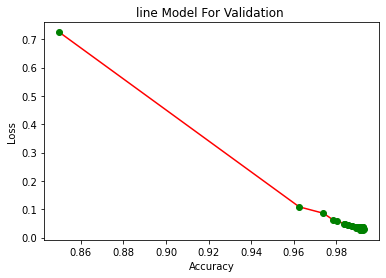

In [ ]:
plt.plot(history.history['val_accuracy'],history.history['val_loss'],"r-")
plt.plot(history.history['val_accuracy'],history.history['val_loss'],"go")
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('line Model For Validation ')
#plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

**Prediction Test**

In [ ]:
finaltestCNV_dir = test_directory
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size

y_pred = model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)
y_pred

Found 10392 images belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float16)

In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 ... 8 8 8]


**Adding Lebel on Test Image**

In [ ]:
test_label = []
ADILabel = 0
BACKLabel = 1
DEBLabel = 2
LYMLabel = 3
MUCLabel = 4
MUSLabel = 5
NORMLabel = 6
STRLabel = 7
TUMLabel = 8



for i in range(1000):
    test_label.append(ADILabel)

for i in range(1069):
    test_label.append(BACKLabel)

for i in range(1207):
    test_label.append(DEBLabel)

for i in range(1233):
    test_label.append(LYMLabel)

for i in range(1026):
    test_label.append(MUCLabel)


for i in range(1364):
    test_label.append(MUSLabel)


for i in range(877):
    test_label.append(NORMLabel)

for i in range(1164):
    test_label.append(STRLabel)


for i in range(1452):
    test_label.append(TUMLabel)


print(test_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import itertools

In [ ]:
array = confusion_matrix(test_label, predicted_class_indices)

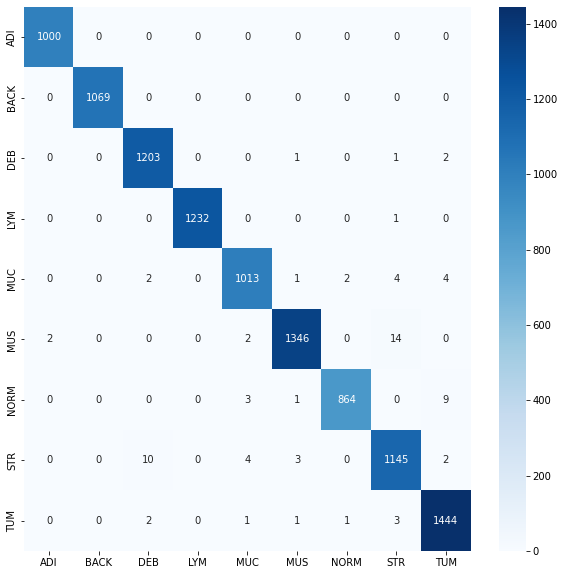

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["ADI", "BACK","DEB","LYM","MUC","MUS","NORM","STR","TUM"],
                  columns = ["ADI", "BACK","DEB","LYM","MUC","MUS","NORM","STR","TUM"])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')